In [2]:
!pip3 install pandas numpy scikit-learn matplotlib seaborn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [4]:
df = pd.read_csv("Churn_Modelling.csv")
print("Shape:", df.shape)
df.head()

Shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Encode Gender: Male=1, Female=0
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# Encode Geography using one-hot encoding
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True


In [7]:
X = df.drop('Exited', axis=1)   # features
y = df['Exited']                # target (0 = Stay, 1 = Churn)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (8000, 11)
Testing set: (2000, 11)


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb.fit(X_train, y_train)

print("✅ Models trained successfully")

✅ Models trained successfully


In [10]:
def evaluate_model(name, model, X_test, y_test, scaled=False):
    if scaled:
        preds = model.predict(X_test_scaled)
        probs = model.predict_proba(X_test_scaled)[:,1]
    else:
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:,1]
    
    print(f"\n=== {name} ===")
    print("Accuracy:", round(accuracy_score(y_test, preds), 4))
    print("ROC-AUC:", round(roc_auc_score(y_test, probs), 4))
    print("Classification Report:\n", classification_report(y_test, preds, target_names=['Stay','Churn']))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

# Evaluate
evaluate_model("Logistic Regression", lr, X_test, y_test, scaled=True)
evaluate_model("Random Forest", rf, X_test, y_test)
evaluate_model("Gradient Boosting", gb, X_test, y_test)


=== Logistic Regression ===
Accuracy: 0.7135
ROC-AUC: 0.7771
Classification Report:
               precision    recall  f1-score   support

        Stay       0.90      0.72      0.80      1593
       Churn       0.39      0.70      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.74      2000

Confusion Matrix:
 [[1142  451]
 [ 122  285]]

=== Random Forest ===
Accuracy: 0.863
ROC-AUC: 0.8534
Classification Report:
               precision    recall  f1-score   support

        Stay       0.87      0.97      0.92      1593
       Churn       0.79      0.45      0.57       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000

Confusion Matrix:
 [[1543   50]
 [ 224  183]]

=== Gradient Boosting ===
Accuracy: 0.867
ROC-AUC: 0.8693
Classification Report:
       

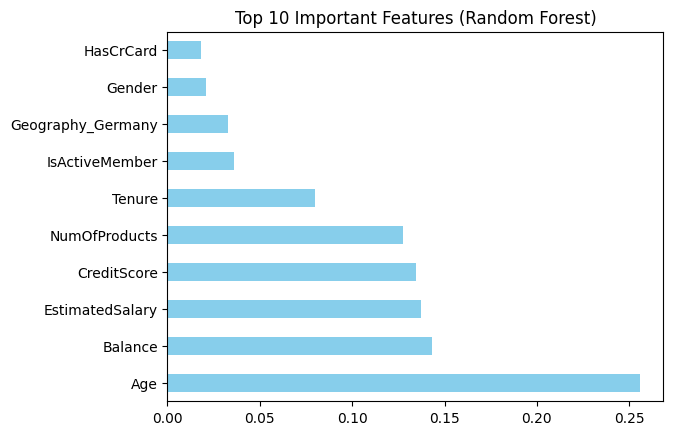

In [11]:
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Important Features (Random Forest)")
plt.show()

In [12]:
# Example customer (random row from test set)
sample = X_test.iloc[0:1]
print("Sample customer data:\n", sample)

# Predict churn
pred = rf.predict(sample)[0]
proba = rf.predict_proba(sample)[0][1]

print("\nPrediction:", "Churn" if pred==1 else "Stay")
print("Churn probability:", round(proba, 2))

Sample customer data:
       CreditScore  Gender  Age  Tenure  Balance  NumOfProducts  HasCrCard  \
5702          585       1   36       7      0.0              2          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  
5702               0         94283.09              False            False  

Prediction: Stay
Churn probability: 0.06
